#### Set experiment parameters in config
For training that terminates in a reasonable timeframe use data in sample_subset/audio.
This is not a real dataset as it consists of 10 images, but the functionality of the code can be examined.
The full dataset can be found here "https://magenta.withgoogle.com/datasets/nsynth#files" It must first be extracted, for example with the function in data_work.ipynb. To use the full dataset, preprocessing is recommend. A function for this purpose can also be found in the data_work notebook. To continue with the experiment, set the parameters of the config to something reasonable for your hardware like done bewlow:

In [1]:
import sys
import os
from pathlib import Path
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(''))))

notebook_dir = Path.cwd()  # Current working directory when notebook is run
project_root = notebook_dir.parent if notebook_dir.name == 'core' else notebook_dir
sys.path.insert(0, str(project_root))
from core.config import load_config
config = load_config()
config.vae.batch_size = 32
config.vae.epochs = 100

In [ ]:
from core.train_vae import train, test, simple_kl_annealing
from core.datasets import HDF5SpectrogramDataset, collate_fn
from core.VAE_models import VAE, CVAE, count_parameters, save_checkpoint

from datetime import datetime


from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import v2
import torch

conv = True

# Define image transformation if wanted for regularization
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(128, 172), antialias=True),
    v2.RandomHorizontalFlip(p=0.5)
    ])


train_data = HDF5SpectrogramDataset(project_root / 'data' / 'train_spectrograms_even.h5', transform=transforms)
test_data = HDF5SpectrogramDataset(project_root / 'data' / 'valid_spectrograms_even.h5')

train_loader = DataLoader(train_data, batch_size=config.vae.batch_size, shuffle=True, pin_memory=True, num_workers=8, persistent_workers=True, prefetch_factor=2)
test_loader = DataLoader(test_data, batch_size=config.vae.batch_size, shuffle=False, pin_memory=True, num_workers=4, persistent_workers=True)

sample_spec = train_data[0] # Sample spectogram 
in_dim = sample_spec.numel() # For spectograms = width * height
image_size = tuple(sample_spec.size())

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join(config.log_dir, timestamp)
os.makedirs(log_dir, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

if conv:
    model = CVAE([128, 172], config.vae.latent_dim, 0.0).to(device)
else:
    model = VAE(in_dim, config.vae.latent_dim, config.vae.n_layers, config.vae.beta_kl).to(device)

print(count_parameters(model))

torch.set_float32_matmul_precision("medium")

optimizer = torch.optim.Adam(model.parameters(), lr=config.vae.lr, weight_decay=config.vae.weight_decay, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.vae.epochs)
writer = SummaryWriter(log_dir)
prev_updates = 0
best_loss = torch.tensor(float('Inf'))
for epoch in range(config.vae.epochs):
    print(f'Epoch {epoch+1}/{config.vae.epochs}')
    beta = simple_kl_annealing(epoch, config.vae.epochs)
    print(f'using beta: {beta}')
    model.set_beta(beta)
    prev_updates = train(model, train_loader, optimizer, prev_updates, config, device=device, writer=writer, conv=conv)
    scheduler.step()
    _, _, test_kl_loss = test(model, test_loader, prev_updates, config, device, writer=writer, conv=True)
    if test_kl_loss < best_loss:
        best_loss = test_kl_loss
        if conv:
            save_checkpoint(model, optimizer, epoch, test_kl_loss, config, conv, image_size)
        else:
            save_checkpoint(model, optimizer, epoch, test_kl_loss, config, conv, in_dim)
    


cuda
34833793
Epoch 1/100
using beta: 0.01


  0%|          | 6/9038 [00:00<18:33,  8.11it/s]  

Step 0 (N samples: 0), Loss: 8834.2197 (Recon: 8834.2188, KL: 0.0007) Grad: 5272.6989


  6%|▌         | 506/9038 [00:11<03:12, 44.41it/s]

Step 500 (N samples: 16,000), Loss: 1462.1222 (Recon: 1445.6715, KL: 16.4507) Grad: 310.0208


 11%|█         | 1006/9038 [00:22<02:57, 45.16it/s]

Step 1,000 (N samples: 32,000), Loss: 1435.2356 (Recon: 1418.0677, KL: 17.1678) Grad: 732.8733


 17%|█▋        | 1506/9038 [00:34<02:59, 41.94it/s]

Step 1,500 (N samples: 48,000), Loss: 979.6647 (Recon: 966.8320, KL: 12.8327) Grad: 687.6525


 22%|██▏       | 2006/9038 [00:45<02:33, 45.78it/s]

Step 2,000 (N samples: 64,000), Loss: 1063.3912 (Recon: 1051.0012, KL: 12.3900) Grad: 1295.5089


 28%|██▊       | 2506/9038 [00:55<02:21, 46.24it/s]

Step 2,500 (N samples: 80,000), Loss: 1059.1073 (Recon: 1044.5088, KL: 14.5985) Grad: 952.9480


 33%|███▎      | 3006/9038 [01:06<02:08, 47.00it/s]

Step 3,000 (N samples: 96,000), Loss: 958.4469 (Recon: 945.0155, KL: 13.4314) Grad: 2669.6678


 39%|███▉      | 3506/9038 [01:18<02:12, 41.83it/s]

Step 3,500 (N samples: 112,000), Loss: 655.1793 (Recon: 644.8223, KL: 10.3570) Grad: 806.8675


 44%|████▍     | 4009/9038 [01:30<01:59, 42.08it/s]

Step 4,000 (N samples: 128,000), Loss: 891.8079 (Recon: 876.5920, KL: 15.2159) Grad: 635.1150


 50%|████▉     | 4509/9038 [01:41<01:42, 44.28it/s]

Step 4,500 (N samples: 144,000), Loss: 625.5754 (Recon: 612.1959, KL: 13.3795) Grad: 2815.9155


 55%|█████▌    | 5009/9038 [01:53<01:29, 44.96it/s]

Step 5,000 (N samples: 160,000), Loss: 780.9575 (Recon: 766.2848, KL: 14.6727) Grad: 555.4445


 61%|██████    | 5509/9038 [02:04<01:22, 42.98it/s]

Step 5,500 (N samples: 176,000), Loss: 660.4344 (Recon: 643.9640, KL: 16.4704) Grad: 2996.0350


 66%|██████▋   | 6006/9038 [02:16<01:34, 31.93it/s]

Step 6,000 (N samples: 192,000), Loss: 709.8839 (Recon: 693.8298, KL: 16.0542) Grad: 2085.2963


 72%|███████▏  | 6506/9038 [02:28<01:00, 41.60it/s]

Step 6,500 (N samples: 208,000), Loss: 556.8604 (Recon: 541.9792, KL: 14.8811) Grad: 2912.7650


 78%|███████▊  | 7006/9038 [02:39<00:47, 43.15it/s]

Step 7,000 (N samples: 224,000), Loss: 681.7130 (Recon: 665.2552, KL: 16.4578) Grad: 2753.1357


 83%|████████▎ | 7506/9038 [02:50<00:33, 45.96it/s]

Step 7,500 (N samples: 240,000), Loss: 500.7007 (Recon: 483.7288, KL: 16.9719) Grad: 2206.6191


 89%|████████▊ | 8006/9038 [03:01<00:22, 45.94it/s]

Step 8,000 (N samples: 256,000), Loss: 540.2377 (Recon: 524.6207, KL: 15.6171) Grad: 1804.9985


 94%|█████████▍| 8506/9038 [03:13<00:12, 41.26it/s]

Step 8,500 (N samples: 272,000), Loss: 348.6032 (Recon: 335.6845, KL: 12.9187) Grad: 1681.1228


100%|█████████▉| 9007/9038 [03:25<00:00, 39.48it/s]

Step 9,000 (N samples: 288,000), Loss: 481.0917 (Recon: 466.0351, KL: 15.0566) Grad: 1575.9137


Testing: 100%|██████████| 397/397 [00:03<00:00, 106.66it/s]


====> Test set loss: 781.4368 (BCE: 764.1075, KLD: 17.3293)
Epoch 2/100
using beta: 0.01


  5%|▌         | 469/9038 [00:11<03:21, 42.48it/s]

Step 9,500 (N samples: 304,000), Loss: 392.0512 (Recon: 378.6866, KL: 13.3646) Grad: 1996.6183


 11%|█         | 970/9038 [00:23<03:08, 42.82it/s]

Step 10,000 (N samples: 320,000), Loss: 571.7382 (Recon: 553.3089, KL: 18.4293) Grad: 793.9149


 16%|█▌        | 1468/9038 [00:34<02:59, 42.13it/s]

Step 10,500 (N samples: 336,000), Loss: 518.9404 (Recon: 502.2585, KL: 16.6820) Grad: 2404.0153


 22%|██▏       | 1968/9038 [00:46<02:39, 44.41it/s]

Step 11,000 (N samples: 352,000), Loss: 365.1535 (Recon: 351.1017, KL: 14.0518) Grad: 713.5638


 27%|██▋       | 2467/9038 [00:57<02:49, 38.82it/s]

Step 11,500 (N samples: 368,000), Loss: 585.9932 (Recon: 570.2774, KL: 15.7158) Grad: 1023.5596


 33%|███▎      | 2971/9038 [01:11<02:23, 42.18it/s]

Step 12,000 (N samples: 384,000), Loss: 435.6557 (Recon: 420.3234, KL: 15.3323) Grad: 1022.6874


 38%|███▊      | 3467/9038 [01:22<02:10, 42.65it/s]

Step 12,500 (N samples: 400,000), Loss: 414.7037 (Recon: 400.6530, KL: 14.0507) Grad: 2144.3337


 44%|████▍     | 3967/9038 [01:34<01:56, 43.57it/s]

Step 13,000 (N samples: 416,000), Loss: 465.5095 (Recon: 446.9486, KL: 18.5609) Grad: 4182.9374


 49%|████▉     | 4467/9038 [01:46<01:56, 39.31it/s]

Step 13,500 (N samples: 432,000), Loss: 443.1150 (Recon: 428.5467, KL: 14.5682) Grad: 5036.1993


 55%|█████▍    | 4970/9038 [01:58<01:33, 43.37it/s]

Step 14,000 (N samples: 448,000), Loss: 557.9575 (Recon: 541.3242, KL: 16.6334) Grad: 1255.3830


 61%|██████    | 5468/9038 [02:09<01:20, 44.44it/s]

Step 14,500 (N samples: 464,000), Loss: 414.1649 (Recon: 399.7720, KL: 14.3929) Grad: 4251.9228


 66%|██████▌   | 5968/9038 [02:20<01:08, 44.80it/s]

Step 15,000 (N samples: 480,000), Loss: 433.3360 (Recon: 419.5347, KL: 13.8014) Grad: 2171.1205


 72%|███████▏  | 6468/9038 [02:32<00:58, 44.15it/s]

Step 15,500 (N samples: 496,000), Loss: 431.5616 (Recon: 416.1743, KL: 15.3873) Grad: 658.3788


 77%|███████▋  | 6968/9038 [02:43<00:46, 44.83it/s]

Step 16,000 (N samples: 512,000), Loss: 484.1146 (Recon: 466.5288, KL: 17.5858) Grad: 5667.7525


 83%|████████▎ | 7468/9038 [02:54<00:34, 45.18it/s]

Step 16,500 (N samples: 528,000), Loss: 474.0331 (Recon: 457.2645, KL: 16.7685) Grad: 1472.2155


 88%|████████▊ | 7968/9038 [03:05<00:24, 44.43it/s]

Step 17,000 (N samples: 544,000), Loss: 415.6366 (Recon: 400.3470, KL: 15.2896) Grad: 3453.4830


 94%|█████████▎| 8468/9038 [03:16<00:12, 44.84it/s]

Step 17,500 (N samples: 560,000), Loss: 407.9811 (Recon: 392.7884, KL: 15.1927) Grad: 2175.0692


 99%|█████████▉| 8968/9038 [03:27<00:01, 45.33it/s]

Step 18,000 (N samples: 576,000), Loss: 403.9767 (Recon: 386.7752, KL: 17.2015) Grad: 1328.2942


Testing: 100%|██████████| 397/397 [00:02<00:00, 136.65it/s]


====> Test set loss: 636.7971 (BCE: 618.5541, KLD: 18.2430)
Epoch 3/100
using beta: 0.01


  5%|▍         | 433/9038 [00:09<03:07, 45.98it/s]

Step 18,500 (N samples: 592,000), Loss: 293.0673 (Recon: 279.4426, KL: 13.6247) Grad: 696.6053


 10%|█         | 933/9038 [00:20<02:59, 45.13it/s]

Step 19,000 (N samples: 608,000), Loss: 475.5863 (Recon: 459.8794, KL: 15.7069) Grad: 7541.5624


 16%|█▌        | 1433/9038 [00:31<02:47, 45.27it/s]

Step 19,500 (N samples: 624,000), Loss: 437.8840 (Recon: 422.1820, KL: 15.7020) Grad: 1257.6176


 21%|██▏       | 1933/9038 [00:42<02:36, 45.52it/s]

Step 20,000 (N samples: 640,000), Loss: 445.4118 (Recon: 429.3384, KL: 16.0734) Grad: 753.0938


 27%|██▋       | 2433/9038 [00:53<02:25, 45.27it/s]

Step 20,500 (N samples: 656,000), Loss: 452.6963 (Recon: 437.6184, KL: 15.0779) Grad: 417.6523


 32%|███▏      | 2933/9038 [01:04<02:16, 44.67it/s]

Step 21,000 (N samples: 672,000), Loss: 309.8647 (Recon: 295.2616, KL: 14.6031) Grad: 1540.1632


 38%|███▊      | 3433/9038 [01:15<02:06, 44.46it/s]

Step 21,500 (N samples: 688,000), Loss: 343.7827 (Recon: 330.1929, KL: 13.5898) Grad: 2159.4260


 44%|████▎     | 3933/9038 [01:26<01:50, 46.01it/s]

Step 22,000 (N samples: 704,000), Loss: 358.8854 (Recon: 343.4226, KL: 15.4628) Grad: 3107.0958


 49%|████▉     | 4433/9038 [01:37<01:43, 44.48it/s]

Step 22,500 (N samples: 720,000), Loss: 419.0624 (Recon: 400.8071, KL: 18.2553) Grad: 2243.4628


 55%|█████▍    | 4933/9038 [01:49<01:31, 44.77it/s]

Step 23,000 (N samples: 736,000), Loss: 429.5723 (Recon: 413.4735, KL: 16.0988) Grad: 1906.5845


 60%|██████    | 5433/9038 [01:59<01:19, 45.39it/s]

Step 23,500 (N samples: 752,000), Loss: 388.1069 (Recon: 368.9872, KL: 19.1197) Grad: 1459.8500


 66%|██████▌   | 5933/9038 [02:10<01:09, 44.99it/s]

Step 24,000 (N samples: 768,000), Loss: 425.4630 (Recon: 408.9828, KL: 16.4803) Grad: 461.5400


 71%|███████   | 6432/9038 [02:22<01:02, 41.66it/s]

Step 24,500 (N samples: 784,000), Loss: 326.8563 (Recon: 311.9947, KL: 14.8616) Grad: 1105.3010


 77%|███████▋  | 6930/9038 [02:34<00:49, 42.36it/s]

Step 25,000 (N samples: 800,000), Loss: 472.5271 (Recon: 453.8693, KL: 18.6578) Grad: 1995.7541


 82%|████████▏ | 7434/9038 [02:46<00:36, 44.55it/s]

Step 25,500 (N samples: 816,000), Loss: 322.1223 (Recon: 308.1039, KL: 14.0184) Grad: 2016.6526


 88%|████████▊ | 7931/9038 [02:58<00:25, 43.07it/s]

Step 26,000 (N samples: 832,000), Loss: 391.5527 (Recon: 374.9197, KL: 16.6330) Grad: 1078.3544


 93%|█████████▎| 8432/9038 [03:10<00:14, 42.81it/s]

Step 26,500 (N samples: 848,000), Loss: 414.2902 (Recon: 396.1155, KL: 18.1747) Grad: 1235.7703


 99%|█████████▉| 8930/9038 [03:21<00:02, 41.45it/s]

Step 27,000 (N samples: 864,000), Loss: 397.7933 (Recon: 380.4727, KL: 17.3206) Grad: 493.5900


Testing: 100%|██████████| 397/397 [00:03<00:00, 120.68it/s]


====> Test set loss: 561.6791 (BCE: 543.0837, KLD: 18.5954)
Epoch 4/100
using beta: 0.01


  4%|▍         | 391/9038 [00:09<03:29, 41.28it/s]

Step 27,500 (N samples: 880,000), Loss: 350.1394 (Recon: 334.9296, KL: 15.2098) Grad: 1291.8174


  4%|▍         | 406/9038 [00:09<03:35, 40.07it/s]

#### Load model and decode random latent codes

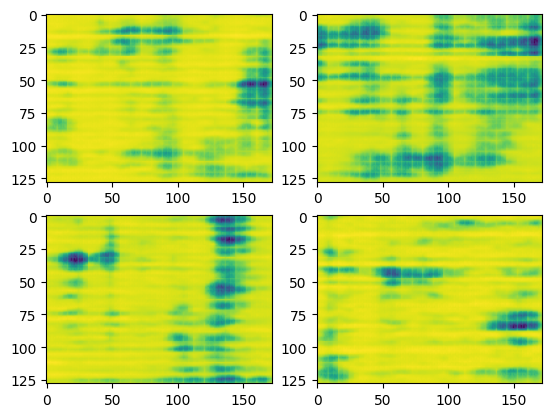

In [3]:
import matplotlib.pyplot as plt
import torch
from VAE_models import load_vae_model
conv = True
model, checkpoint = load_vae_model('./models/conv_vae/c_vae_checkpoint_20250731-132315.pt', 'cuda', conv=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()

z = torch.randn(4, checkpoint['config']['latent_dim']).to(device)
with torch.no_grad():
    samples = model.decode(z)
samples = samples.cpu().view(4, 128, 172).numpy()
plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(samples[i])

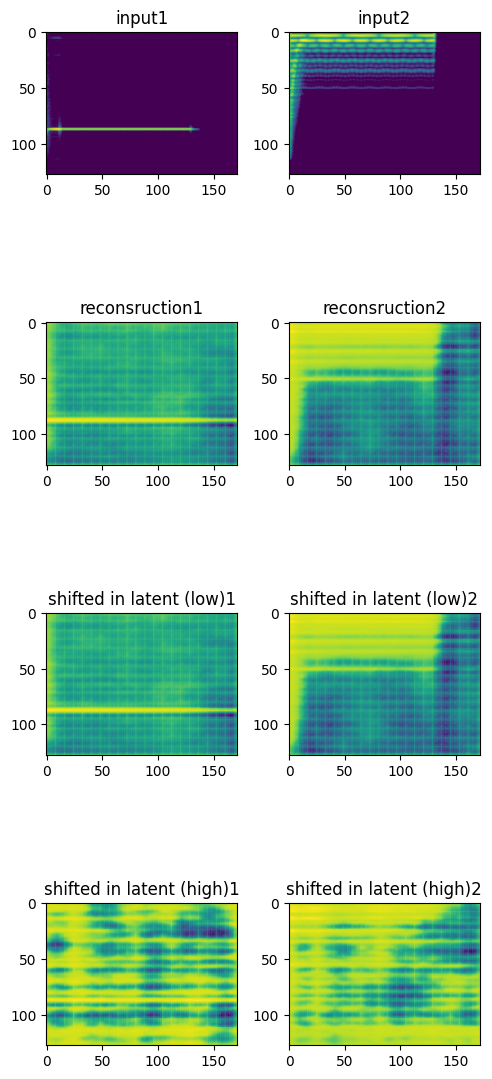

In [5]:
from datasets import HDF5SpectrogramDataset
from torch.utils.data import DataLoader
import numpy as np
num_samples = 2
train_data = HDF5SpectrogramDataset(project_root / 'data' / 'train_spectrograms_even.h5')
train_loader = DataLoader(train_data, batch_size=num_samples, shuffle=True)

inputs = next(iter(train_loader))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inputs = inputs.to(device)
with torch.no_grad():
    if not conv:
        inputs = inputs.view(num_samples, -1)  # Flatten the data when not using convolutional VAE
    else:
        inputs = inputs.view(num_samples, 1, 128, 172)
    dist = model.encode(inputs)
    z_s = model.reparameterize(dist)
    recons = model.decode(z_s).cpu().view(num_samples, 128, 172).numpy()
    shifted_z_s_high = z_s + torch.rand_like(z_s) * 5.0
    shifted_z_s_low = z_s + torch.rand_like(z_s) * 000.1
    shifted_high = model.decode(shifted_z_s_high).cpu().view(num_samples, 128, 172).numpy()
    shifted_low = model.decode(shifted_z_s_low).cpu().view(num_samples, 128, 172).numpy()
    inputs = inputs.cpu().view(num_samples, 128, 172).numpy()
images = np.array([inputs, recons, shifted_high, shifted_low]).reshape((8, 128, 172))
plt.figure(figsize=[5,12])
for i in range(num_samples):
    plt.subplot(4,num_samples,i+1)
    plt.imshow(inputs[i])
    plt.title(f'input{i+1}')
    plt.subplot(4,num_samples,i+num_samples+1)
    plt.imshow(recons[i])
    plt.title(f'reconsruction{i+1}')
    plt.subplot(4,num_samples,i+2*num_samples+1)
    plt.imshow(shifted_low[i])
    plt.title(f'shifted in latent (low){i+1}')
    plt.subplot(4,num_samples,i+3*num_samples+1)
    plt.imshow(shifted_high[i])
    plt.title(f'shifted in latent (high){i+1}')
plt.tight_layout()



In [ ]:
import pandas as pd
df = pd.